# A comparison of actual thrombolysis rates across hospitals: subgroup analysis

## Plain English summary

We have previously predicted the thrombolysis use in subgroups, if all hospitals saw the same 10 thousand patients. In this notebook we look at the same subgroup analysis, this time for observed thrombolysis use. One difference between this and the previous work, is that when we look at observed thrombolysis use, then the patients in the subgroups are different at each hospital, but we can still look for agreement in general patterns.

Informed by the SHAP values, we analysed the observed use of thrombolysis in subgroups of patients: one ‘ideally’ thrombolysable patient, nine ‘sub-optimal’ thrombolysable patient subgroups (one subgroup per feature), and subgroups with combinations of sub-optimal features. We based the ideally thrombolysable definition on observing the relationships between feature values and thrombolysis use, and for each ‘sub optimal’ subgroup we chose the feature value that is less desirable for choosing to use thrombolysis (this is either a feature value that corresponds with a SHAP value of zero, or the least favourable value for binary features). 

The patient subgroups are defined as:
  * An 'ideally' thrombolysable patient:
    * Mid-level stroke severity (NIHSS in range 10-25)
    * Short arrival-to-scan time (less than 30 minutes)
    * Stroke caused by infarction
    * Precise stroke onset time known
    * No pre-stroke disability (mRS 0)
    * Not taking atrial fibrillation anticoagulants
    * Short onset-to-arrival time (less than 90 minutes)
    * Younger than 80 years old
    * Onset not during sleep
  * Patients with a milder stroke severity (NIHSS less than 5)
  * Patients where stroke onset time known imprecisely
  * Patients with existing pre-stroke disability (mRS greater than 2)
  * Patients with a haemorrhagic stroke
  * Patients with 60-90 minutes arrival-to-scan time
  * Patients with use of AF anticoagulants
  * Patients with 150-180 minutes onset-to-arrival time
  * Patients with onset during sleep
  * Patients aged over 80 years old

As with the predicted thrombolysis use (if all hopsitals saw the same patients), we see the same patterns. All stroke units show high expected thrombolysis in a set of 'ideal' thrombolysis patients, but vary in expected use in subgroups with low stroke severity, no precise onset time, or existing pre-stroke disability. If a stroke unit showed lower thombolysis in one of these subgroups they also tended to show lower thrombolysis rates in the other subgroups - suggesting a shared caution in use of thrombolysis in 'less ideal' patients.

## Data 

This analysis is for patients who arrive within 4 hours of known stroke onset. The data is the observed thrombolsyis use at each hopsital (not modelled/predicted thrombolysis use).

## Aims

* Look at actual thrombolysis use in these subgroups of patients (in addiitonal to total thrombolysis use):
  * An *ideal* thrombolysable patient:
    * Stroke severity NIHSS in range 10-25
    * Arrival-to-scan time < 30 minutes
    * Stroke type = infarction
    * Precise onset time = True
    * Prior diability level (mRS) = 0
    * No use of AF anticoagulants
    * Onset-to-arrival time < 90 minutes
    * Age < 80 years
    * Onset during sleep = False
  * Mild stroke severity (NIHSS < 5)
  * No precise onset time
  * Existing pre-stroke disability (mRS > 2)
  * Older than 80 years old
  * A haemorrhagic stroke
  * Arrival-to-scan time 60-90 minutes
  * Onset-to-arrival time 150-180 minutes
  * Use of AF anticoagulants
  * Onset during sleep

## Observations

* The three subgroups of NIHSS <5, no precise stroke onset time, and prestroke mRS > 2, all had reduced thrombolysis use (compared to all patients), and combining these non-ideal features reduced thrombolysis use further.
* The three subgroups of NIHSS <5, no precise stroke onset time, and prestroke mRS > 2, tended to reduce in parallel, along with total thrombolysis use, suggesting a shared caution in use of thrombolysis in 'less ideal' patients. 
* The observed and predicted subgroup analysis show very similar general patterns (with r-sqaured=0.93). Some differences exist:
  * The use of thrombolysis in *ideal* patients is a little low in the observed vs predicted results (mean hospital thrombolysis use = 89% vs 99%).
  * The predicted results show a stronger effect of combining non-ideal features.
  * The observed thrombolysis rate shows higher between-hospital variation than the predicted thrombolysis rate. This may be partly explained by the observed thrombolysis rate being on different patients at each hospital, but may also be partly explained by actual use of thrombolysis being slightly more variable than predicted thrombolysis use (which will follow general hospital patterns, and will not include, for example, between-clinician variation at each hospital).

## Import packages

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

## Set filenames

In [2]:
# Set up strings (describing the model) to use in filenames
number_key_features = 10
model_text = f'xgb_{number_key_features}_features_10k_cohort'
notebook = '15a'

## Import data

In [3]:
# Load one k-fold, and join to get full data
data_loc = '../data/kfold_5fold/'
train = pd.read_csv(data_loc + 'train_0.csv')
test = pd.read_csv(data_loc + 'test_0.csv')
data = pd.concat([train, test])

# Restrict data fields and rename
with open("./output/01_feature_name_dict.json") as json_file:
    feature_name_dict = json.load(json_file)
number_of_features_to_use = 10
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
key_features.append('S2Thrombolysis')
data = data[key_features]
data.rename(columns=feature_name_dict, inplace=True)

In [4]:
data.head()

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,Thrombolysis
0,14.0,0,24.0,1,0,APXEE8191H,0,106.0,0,92.5,0
1,8.0,1,27.0,1,0,EQZZZ5658G,0,144.0,0,72.5,1
2,18.0,1,2.0,0,0,QOAPO4699N,0,83.0,0,72.5,1
3,19.0,1,12.0,1,4,JINXD0311F,0,78.0,0,57.5,1
4,22.0,1,27.0,1,3,HBFCN1575G,1,145.0,0,82.5,1


## Get thrombolysis use in subgroups at each hospital

Store in dictionary

In [5]:
# Initialise dictionary to store a dictionary per hospital 
#   (using hosptial name as key)
dict_results = dict()

# Group data by hospital
grouped_data = data.groupby('Stroke team')

# Loop through hospitals
for hospital, hosp_data in grouped_data:
    
    # Initialise dictionary for this hospital
    dict_hosp_results = dict()
    
    # Calculate thrombolysis rate for all patients attending hospital
    dict_hosp_results['All patients'] = hosp_data['Thrombolysis'].mean()

    # Calculate thrombolysis rate for ideal patients
    mask = ((hosp_data['Stroke severity'] <= 25) &
        (hosp_data['Stroke severity'] >= 10) & 
        (hosp_data['Arrival-to-scan time'] <= 30) &
        (hosp_data['Infarction'] == 1) &
        (hosp_data['Precise onset time'] == 1) &
        (hosp_data['Prior disability level'] == 0) &
        (hosp_data['Use of AF anticoagulants'] == 0) &
        (hosp_data['Onset-to-arrival time'] <= 90) &
        (hosp_data['Age'] < 80) &
        (hosp_data['Onset during sleep'] == 0)
        )
    dict_hosp_results['Ideal'] = hosp_data[mask]['Thrombolysis'].mean()

    # Calculate thrombolysis rate for mild stroke (NIHSS < 5)
    mask = hosp_data['Stroke severity'] < 5
    dict_hosp_results['NIHSS < 5'] = hosp_data[mask]['Thrombolysis'].mean()

    # Calculate thrombolysis rate for no precise onset time
    mask = hosp_data['Precise onset time'] == 0
    dict_hosp_results['Estimated onset time'] = (
                                        hosp_data[mask]['Thrombolysis'].mean())

    # Calculate thrombolysis rate for patients with prior disability
    mask = hosp_data['Prior disability level'] > 2
    dict_hosp_results['mRS > 2'] = hosp_data[mask]['Thrombolysis'].mean()

    # Calculate thrombolysis rate for > 80 year olds
    mask = hosp_data['Age'] > 80 
    dict_hosp_results['Age > 80'] = hosp_data[mask]['Thrombolysis'].mean()
    
    # Calculate thrombolysis rate for arrival-to-scan time 60-90 mins
    mask = ((hosp_data['Arrival-to-scan time'] > 60) & 
            (hosp_data['Arrival-to-scan time'] <= 90))
    dict_hosp_results['Arrival-to-scan 60-90'] = (
                                        hosp_data[mask]['Thrombolysis'].mean())
    
    # Calculate thrombolysis rate for haemorrhagic stroke
    mask = hosp_data['Infarction'] == 0
    dict_hosp_results['Haemorrhagic'] = hosp_data[mask]['Thrombolysis'].mean()

    # Calculate thrombolysis rate for patients who use AF anticoagulants
    mask = hosp_data['Use of AF anticoagulants'] == 1
    dict_hosp_results['Used AF anticoagulants'] = (
                                        hosp_data[mask]['Thrombolysis'].mean())

    # Calculate thrombolysis rate for onset-to-arrival time 150-180 mins
    mask = ((hosp_data['Onset-to-arrival time'] > 150) & 
            (hosp_data['Onset-to-arrival time'] <= 180))
    dict_hosp_results['Onset-to-arrival time 150-180'] = (
                                        hosp_data[mask]['Thrombolysis'].mean())

    # Calculate thrombolysis rate for onset during sleep
    mask = hosp_data['Onset during sleep'] == 1
    dict_hosp_results['Onset during sleep'] = (
                                        hosp_data[mask]['Thrombolysis'].mean())

    # Calculate thrombolysis rate for mild stroke (NIHSS < 5) & no precise onset
    mask = ((hosp_data['Stroke severity'] < 5) & 
            (hosp_data['Precise onset time'] == 0))
    dict_hosp_results['NIHSS + Precise'] = (
                                        hosp_data[mask]['Thrombolysis'].mean())

    # Calculate thrombolysis rate for mild stroke (NIHSS < 5) & prestroke 
    #   disability
    mask = ((hosp_data['Stroke severity'] < 5) & 
            (hosp_data['Prior disability level'] > 2))
    dict_hosp_results['NIHSS + Disability'] = (
                                        hosp_data[mask]['Thrombolysis'].mean())

    # Calculate thrombolysis rate for no precise onset & prestroke disability
    mask = ((hosp_data['Precise onset time'] == 0) & 
            (hosp_data['Prior disability level'] > 2))
    dict_hosp_results['Precise + Disability'] = (
                                        hosp_data[mask]['Thrombolysis'].mean())

    # Calculate thrombolysis rate for NIHSS < 5, no precise onset, prestroke 
    #   disability
    mask = ((hosp_data['Stroke severity'] < 5) &
            (hosp_data['Precise onset time'] == 0) & 
            (hosp_data['Prior disability level'] > 2))
    dict_hosp_results['NIHSS + Precise + Disability'] = (
                                        hosp_data[mask]['Thrombolysis'].mean())

    # Add dictionary of hospital results to main dictionary (using hospital
    #   name as key)
    dict_results[hospital] = dict_hosp_results

# Create dataframe of results (hospital per row, patient subgroup thrombolysis
#   rate per column)
df_results = pd.DataFrame(dict_results).T

# Convert to percent
df_results *= 100 
df_results

,All patients,Ideal,NIHSS < 5,Estimated onset time,mRS > 2,Age > 80,Arrival-to-scan 60-90,Haemorrhagic,Used AF anticoagulants,Onset-to-arrival time 150-180,Onset during sleep,NIHSS + Precise,NIHSS + Disability,Precise + Disability,NIHSS + Precise + Disability
AGNOF1041H,35.246843,82.051282,15.210356,18.623482,21.379310,29.189189,11.538462,0.0,8.849558,31.958763,2.777778,2.409639,0.000000,8.771930,0.000000
AKCGO9726K,36.974790,86.206897,23.049645,18.539326,33.887043,35.044248,16.981132,0.0,22.155689,33.333333,4.166667,8.275862,10.606061,17.177914,4.761905
AOBTM3098N,21.880342,80.000000,2.690583,5.813953,11.926606,18.309859,10.843373,0.0,5.128205,13.461538,2.040816,0.000000,0.000000,5.555556,0.000000
APXEE8191H,22.648084,100.000000,6.329114,12.356322,13.636364,20.270270,2.941176,0.0,3.061224,21.153846,3.333333,2.597403,0.000000,5.333333,0.000000
ATDID5461S,24.038462,100.000000,14.150943,2.727273,9.756098,16.265060,25.352113,0.0,0.000000,15.000000,0.000000,0.000000,7.142857,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPKYH1768F,24.605678,87.500000,5.185185,2.409639,11.475410,21.568627,21.621622,0.0,6.250000,20.000000,0.000000,0.000000,5.555556,0.000000,0.000000
YQMZV4284N,23.617021,100.000000,7.389163,6.074766,20.754717,22.594142,3.389831,0.0,5.357143,12.500000,0.000000,0.000000,2.439024,5.681818,0.000000
ZBVSO0975W,25.000000,76.923077,12.435233,14.705882,20.512821,23.560209,0.000000,0.0,1.886792,28.205128,0.000000,22.222222,0.000000,4.166667,0.000000
ZHCLE1578P,22.363946,100.000000,6.067416,22.070145,18.181818,20.000000,1.587302,0.0,6.410256,16.363636,NaN,6.067416,2.325581,18.279570,2.325581


## Plot results

Plot data for 6 patient subgroups (all patients, ideal candidate for thrombolysis, and four suboptimal individual features)

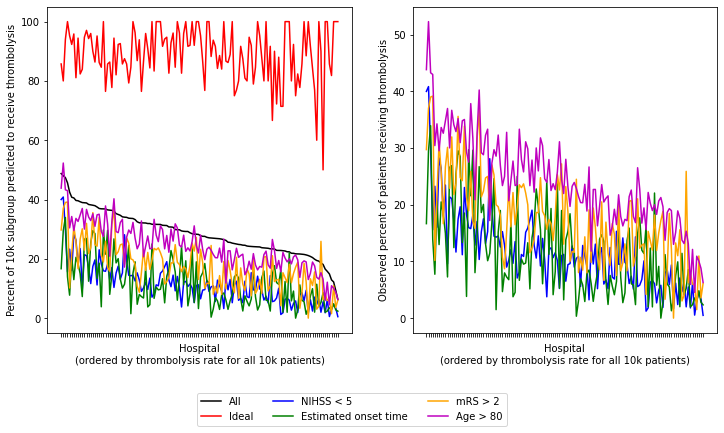

In [6]:
df_sorted_results = df_results.sort_values('All patients', ascending=False)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax1.plot(df_sorted_results['All patients'], label='All', c='k')
ax1.plot(df_sorted_results['Ideal'], label='Ideal', c='r')
ax1.plot(df_sorted_results['NIHSS < 5'], label='NIHSS < 5', c='b')
ax1.plot(df_sorted_results['Estimated onset time'], 
         label='Estimated onset time', c='g')
ax1.plot(df_sorted_results['mRS > 2'], label='mRS > 2', c='orange')
ax1.plot(df_sorted_results['Age > 80'], label='Age > 80', c='m')
ax1.set_xticklabels([])
ax1.set_xlabel('Hospital\n(ordered by thrombolysis rate for all 10k patients)')
ax1.set_ylabel('Percent of 10k subgroup predicted to receive thrombolysis')
ax1.legend(loc='lower center', ncol=3, bbox_to_anchor=(1, -0.3))

ax2 = fig.add_subplot(122)
ax2.plot(df_sorted_results['NIHSS < 5'], label='NIHSS < 5', c='b')
ax2.plot(df_sorted_results['Estimated onset time'], 
         label='Estimated onset time', c='g')
ax2.plot(df_sorted_results['mRS > 2'], label='mRS > 2', c='orange')
ax2.plot(df_sorted_results['Age > 80'], label='Age > 80', c='m')
ax2.set_xticklabels([])
ax2.set_xlabel('Hospital\n(ordered by thrombolysis rate for all 10k patients)')
ax2.set_ylabel('Observed percent of patients receiving thrombolysis')

plt.savefig(f'./output/{notebook}_{model_text}_selected_subgroups.jpg', dpi=300, 
            bbox_inches='tight')

plt.show()

Plot data for all patient subgroups (all patients, ideal candidate for thrombolysis, and all nine individual features)

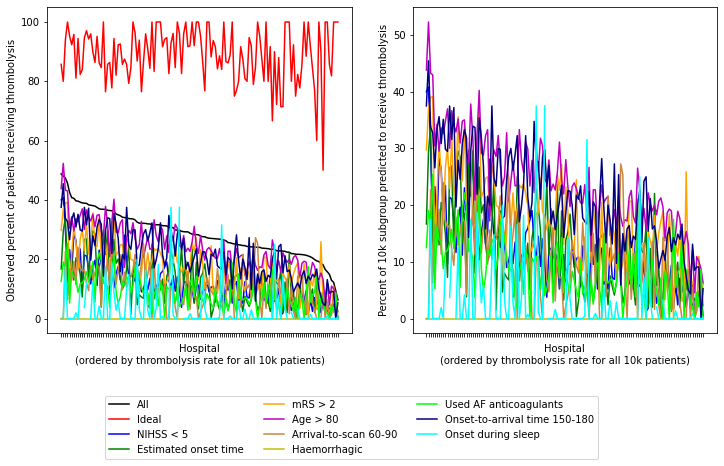

In [7]:
df_sorted_results = df_results.sort_values('All patients', ascending=False)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax1.plot(df_sorted_results['All patients'], label='All', c='k')
ax1.plot(df_sorted_results['Ideal'], label='Ideal', c='r')
ax1.plot(df_sorted_results['NIHSS < 5'], label='NIHSS < 5', c='b')
ax1.plot(df_sorted_results['Estimated onset time'], 
         label='Estimated onset time', c='g')
ax1.plot(df_sorted_results['mRS > 2'], label='mRS > 2', c='orange')
ax1.plot(df_sorted_results['Age > 80'], label='Age > 80', c='m')
ax1.plot(df_sorted_results['Arrival-to-scan 60-90'], 
         label='Arrival-to-scan 60-90', c='peru')
ax1.plot(df_sorted_results['Haemorrhagic'], label='Haemorrhagic', c='y')
ax1.plot(df_sorted_results['Used AF anticoagulants'], 
         label='Used AF anticoagulants', c='lime')
ax1.plot(df_sorted_results['Onset-to-arrival time 150-180'], 
         label='Onset-to-arrival time 150-180', c='navy')
ax1.plot(df_sorted_results['Onset during sleep'],
         label='Onset during sleep', c='aqua')
ax1.set_xticklabels([])
ax1.set_xlabel('Hospital\n(ordered by thrombolysis rate for all 10k patients)')
ax1.set_ylabel('Observed percent of patients receiving thrombolysis')
ax1.legend(loc='lower center', ncol=3, bbox_to_anchor=(1, -0.4))

ax2 = fig.add_subplot(122)
ax2.plot(df_sorted_results['NIHSS < 5'], label='NIHSS < 5', c='b')
ax2.plot(df_sorted_results['Estimated onset time'], 
         label='Estimated onset time', c='g')
ax2.plot(df_sorted_results['mRS > 2'], label='mRS > 2', c='orange')
ax2.plot(df_sorted_results['Age > 80'], label='Age > 80', c='m')
ax2.plot(df_sorted_results['Arrival-to-scan 60-90'], 
         label='Arrival-to-scan 60-90', c='peru')
ax2.plot(df_sorted_results['Haemorrhagic'], label='Haemorrhagic', c='y')
ax2.plot(df_sorted_results['Used AF anticoagulants'], 
         label='Used AF anticoagulants', c='lime')
ax2.plot(df_sorted_results['Onset-to-arrival time 150-180'], 
         label='Onset-to-arrival time 150-180', c='navy')
ax2.plot(df_sorted_results['Onset during sleep'], 
         label='Onset during sleep', c='aqua')
ax2.set_xticklabels([])
ax2.set_xlabel('Hospital\n(ordered by thrombolysis rate for all 10k patients)')
ax2.set_ylabel('Percent of 10k subgroup predicted to receive thrombolysis')

plt.savefig(f'./output/{notebook}_{model_text}_all_subgroups.jpg', 
            dpi=300, bbox_inches='tight')

plt.show()

## Show a summary of results as table (observed dataset)

In [8]:
df_results.describe().T

,count,mean,std,min,25%,50%,75%,max
All patients,132.0,28.618779,7.645344,6.250000,23.513019,28.007450,33.659365,48.756219
Ideal,132.0,89.175667,9.197675,50.000000,83.982143,90.454545,96.038462,100.000000
NIHSS < 5,132.0,11.422620,6.965480,0.490196,6.420988,10.572275,14.489520,40.845070
Estimated onset time,132.0,11.576738,7.882359,0.000000,5.263158,10.027830,16.461749,33.949192
mRS > 2,132.0,17.225861,8.150170,0.000000,11.085627,17.004327,22.443219,39.166667
Age > 80,132.0,24.086885,8.144390,4.545455,18.956249,23.205515,29.754550,52.307692
Arrival-to-scan 60-90,132.0,10.242127,6.820131,0.000000,5.119243,10.741758,14.829545,27.272727
Haemorrhagic,132.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Used AF anticoagulants,132.0,8.686992,5.319644,0.000000,4.875579,8.333333,12.007519,25.373134
Onset-to-arrival time 150-180,132.0,21.231160,8.633019,0.000000,14.787582,20.521390,28.007164,45.454545


## Show a summary of results as violin plot (observed dataset)
Each violin represents the range of predicted thrombolysis rate across the 132 hosptials for a patient subgroup (selected from the 10k patient cohort)

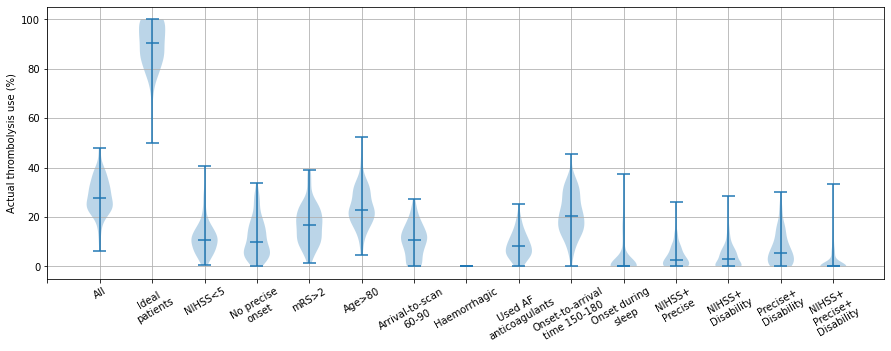

In [9]:
cols = ['All patients', 'Ideal', 'NIHSS < 5', 'Estimated onset time', 'mRS > 2', 
        'Age > 80', 'Arrival-to-scan 60-90', 'Haemorrhagic', 
        'Used AF anticoagulants', 'Onset-to-arrival time 150-180', 
        'Onset during sleep', 'NIHSS + Precise', 'NIHSS + Disability', 
        'Precise + Disability', 'NIHSS + Precise + Disability']


labels = ['', 'All', 'Ideal\npatients', 'NIHSS<5', 'No precise\nonset', 'mRS>2',
          'Age>80', 'Arrival-to-scan\n60-90', 'Haemorrhagic', 
          'Used AF\nanticoagulants', 'Onset-to-arrival\ntime 150-180', 
          'Onset during\nsleep','NIHSS+\nPrecise', 'NIHSS+\nDisability', 
          'Precise+\nDisability', 'NIHSS+\nPrecise+\nDisability']

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot()
ax.violinplot(df_results[cols].dropna(), showmedians=True)
ax.set_ylabel('Actual thrombolysis use (%)')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=30)
ax.grid()
plt.savefig(f'./output/{notebook}_{model_text}_'
            f'actual_subgroup_violin_all_features.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

## Compare observed results with model results (predicted hospital thrombolysis rate for each subgroup created from the 10k cohort)
**Display data as boxplots**

Read in model results from notebook 15.

In [10]:
model_results = pd.read_csv(f'./output/15_{model_text}_groups.csv', 
                            index_col='Unnamed: 0')

Define the feature order as order of feature importance (the same order as used in notebook 03a for the violin plots). Add on a combination subgroup as an example.

In [11]:
cols = ['All patients', 'Ideal', 'Haemorrhagic', 'Arrival-to-scan 60-90', 
        'NIHSS < 5', 'Estimated onset time', 'mRS > 2', 
        'Used AF anticoagulants', 'Onset-to-arrival time 150-180', 
        'Age > 80', 'Onset during sleep', 'NIHSS + Precise']
labels = ['', 'All', 'Ideal\npatients', 'Haemorrhagic', 
          'Arrival-to-scan\n60-90', 'NIHSS<5', 'Estimated\nonset', 'mRS>2', 
          'Used AF\nanticoagulants', 'Onset-to-arrival\ntime 150-180', 'Age>80', 
          'Onset during\nsleep', 'NIHSS<5 +\nEstimated onset']

Plot boxplots in subplots.

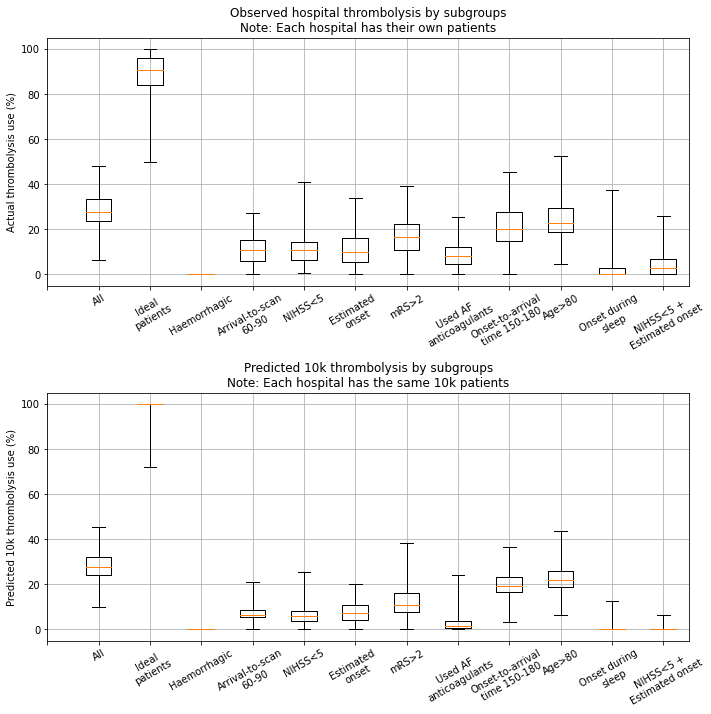

In [12]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(211)
ax1.boxplot(df_results[cols].dropna(),whis=[0,100])
ax1.set_ylabel('Actual thrombolysis use (%)')
ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels, rotation=30)
ax1.grid()
ax1.set_title('Observed hospital thrombolysis by subgroups\n'
              'Note: Each hospital has their own patients')

ax2 = fig.add_subplot(212)
ax2.boxplot(model_results[cols].dropna(),whis=[0,100])
ax2.set_ylabel('Predicted 10k thrombolysis use (%)')
ax2.set_xticks(range(len(labels)))
ax2.set_xticklabels(labels, rotation=30)
ax2.grid()
ax2.set_title('Predicted 10k thrombolysis by subgroups\n'
              'Note: Each hospital has the same 10k patients')

plt.tight_layout(pad=1)
plt.savefig(f'./output/{notebook}_{model_text}_'
            f'actual_vs_modelled_subgroup_boxplot.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

## Calculate standard deviation and coefficient of variation for each feature.

Coefficient of variation represents the extent of variability wrt mean.

It is defined as *std dev / mean* (https://en.wikipedia.org/wiki/Coefficient_of_variation)

Haemorragic has mean = 0, so not possible to calculate coefficient of variation for this feature

In [13]:
cv_cols = ['All patients', 'Ideal', 'Arrival-to-scan 60-90', 
        'NIHSS < 5', 'Estimated onset time', 'mRS > 2', 
        'Used AF anticoagulants', 'Onset-to-arrival time 150-180', 
        'Age > 80', 'Onset during sleep', 'NIHSS + Precise']

# Calculate standard deviation of thrombolysis rate for each patient subgroup
temp_df1 = pd.DataFrame(data=df_results[cols].std(),
                        columns=["standard deviation"])

# Define function to calculate cv
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100 
# Calculate cv of thrombolysis rate for each patient subgroup
temp_df2 = pd.DataFrame(data=df_results[cv_cols].apply(cv),
                        columns=["coefficient of variation"])

# Join both dataframes together
temp_df1 = temp_df1.join(temp_df2)

temp_df1

,standard deviation,coefficient of variation
All patients,7.645344,26.714431
Ideal,9.197675,10.314108
Haemorrhagic,0.000000,NaN
Arrival-to-scan 60-90,6.820131,66.589004
NIHSS < 5,6.965480,60.979706
Estimated onset time,7.882359,68.087912
mRS > 2,8.150170,47.313570
Used AF anticoagulants,5.319644,61.236898
Onset-to-arrival time 150-180,8.633019,40.662020
Age > 80,8.144390,33.812551


### Check correlations between pairs of patient subgroups (from the observed dataset)

In [14]:
features = ['All patients', 'Ideal', 'NIHSS < 5', 'Estimated onset time', 'mRS > 2',
            'Age > 80', 'Arrival-to-scan 60-90', 'Haemorrhagic', 
            'Used AF anticoagulants', 'Onset-to-arrival time 150-180',
            'Onset during sleep']

print ('Correlations between subgroups:')
print ('-------------------------------')

# Loop through all features
for feat1 in features:
    # Loop through all features from the chosen feature
    for feat2 in features[features.index(feat1)+1:]:
        # If can, calculate correlation between feature pair
        try:
            slope, intercept, r_value, p_value, std_err = \
                stats.linregress(df_results[feat1],df_results[feat2])
            print (f'{feat1} - {feat2}: r-square = {r_value**2:0.3f}, '
                   f'p = {p_value:0.3f}')

        # Otherwise report not possible
        except:
            print (f'{feat1} - {feat2}: Correlation cannot be calulated')

Correlations between subgroups:
-------------------------------
All patients - Ideal: r-square = 0.006, p = 0.365
All patients - NIHSS < 5: r-square = 0.661, p = 0.000
All patients - Estimated onset time: r-square = 0.344, p = 0.000
All patients - mRS > 2: r-square = 0.528, p = 0.000
All patients - Age > 80: r-square = 0.801, p = 0.000
All patients - Arrival-to-scan 60-90: r-square = 0.158, p = 0.000
All patients - Haemorrhagic: r-square = 0.000, p = 1.000
All patients - Used AF anticoagulants: r-square = 0.321, p = 0.000
All patients - Onset-to-arrival time 150-180: r-square = 0.663, p = 0.000
All patients - Onset during sleep: r-square = nan, p = nan
Ideal - NIHSS < 5: r-square = 0.003, p = 0.520
Ideal - Estimated onset time: r-square = 0.000, p = 0.875
Ideal - mRS > 2: r-square = 0.010, p = 0.258
Ideal - Age > 80: r-square = 0.004, p = 0.491
Ideal - Arrival-to-scan 60-90: r-square = 0.002, p = 0.583
Ideal - Haemorrhagic: r-square = 0.000, p = 1.000
Ideal - Used AF anticoagulants: r-

/home/kerry/miniconda3/envs/samuel2/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/kerry/miniconda3/envs/samuel2/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/kerry/miniconda3/envs/samuel2/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)


## Analyse correlation between observed and predicted subgroup thrombolysis use
Collate results

In [15]:
df_compare = pd.DataFrame()
df_compare['predicted'] = model_results.values.flatten()
df_compare['observed'] = df_results.values.flatten()
df_compare.dropna(inplace=True)

Create scatter plot

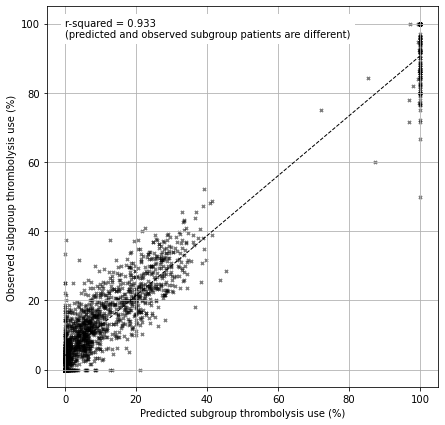

In [16]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.scatter(df_compare['predicted'], df_compare['observed'], 
    marker='x', s=10, c='k', alpha=0.5)

ax.set_xlabel('Predicted subgroup thrombolysis use (%)')
ax.set_ylabel('Observed subgroup thrombolysis use (%)')

# Calculate best fit
slope, intercept, r_value, p_value, std_err = \
        stats.linregress(df_compare['predicted'], df_compare['observed'])

# Plot best fit
ax.plot([0, 100], [intercept, intercept + (100 * slope)], 
    linestyle='--', c='k', linewidth=1)

text = (f'r-squared = {r_value**2:0.3f}\n'
    '(predicted and observed subgroup patients are different)')

ax.text(0, 96, text, bbox=dict(facecolor='white', edgecolor='white'))
ax.grid()
plt.savefig(f'./output/{notebook}_{model_text}_subgroup_correlation.jpg', 
            dpi=300)
plt.show()

The observed and predicted subgroup analysis show very similar general patterns (with r-squared=0.93). 